In [1]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
import random
import glob
import time

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Visualizations will be shown in the notebook.
%matplotlib inline

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb, GRAY
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 1 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16 # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 720] # Min and max in y to search in slide_window()
x_start_stop = [200, 1180] # ditto for x
pct_overlap = 0.7 # sliding window overlap percentage
heatmap_thresh = 33
num_frames = 30 # number of video frames over which to accumulate heatmap
min_ar, max_ar = 0.7, 3.0 # bounding box acceptable aspect ratio range
small_bbox_area, close_y_thresh = 80*80, 500
min_bbox_area = 40*40

In [2]:
# Read in car and non-car images
car_images = glob.glob('vehicles/**/*.png', recursive=True)
notcar_images = glob.glob('non-vehicles/**/*.png', recursive=True)

print('Car Images: ',len(car_images))
print('Non-car Images: ',len(notcar_images))
print(car_images[0])
print(notcar_images[0])

Car Images:  8792
Non-car Images:  8968
vehicles/GTI_Right/image0765.png
non-vehicles/GTI/image2678.png


In [3]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    """
    Return HOG features and visualization (optionally)
    """
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
            cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False,
            visualise=True, feature_vector=False)
        return features, hog_image
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
            cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False,
            visualise=False, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=8, 
                        pix_per_cell=8, cell_per_block=4, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
        
    # Return list of feature vectors
    return features

Image Shape:  (64, 64, 3)


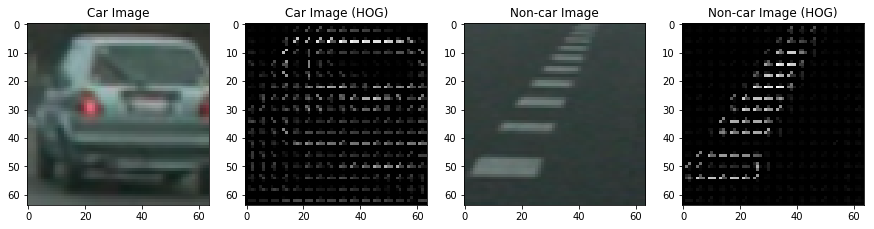

In [4]:
image = mpimg.imread(car_images[0])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

image2 = mpimg.imread(notcar_images[0])
gray2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

feat, hog_image = get_hog_features(gray, orient=8, pix_per_cell=4, cell_per_block=1, vis=True, feature_vec=False)
feat2, hog_image2 = get_hog_features(gray2, orient=8, pix_per_cell=4, cell_per_block=1, vis=True, feature_vec=False)

print('Image Shape: ',image.shape)

plt.rcParams["figure.figsize"] = [15, 10]
plt.subplot(141)
plt.imshow(image,'gray')
plt.title('Car Image')
plt.subplot(142)
plt.imshow(hog_image,'gray')
plt.title('Car Image (HOG)')
plt.subplot(143)
plt.imshow(image2,'gray')
plt.title('Non-car Image')
plt.subplot(144)
plt.imshow(hog_image2,'gray')
plt.title('Non-car Image (HOG)')

In [5]:
car_features = extract_features(car_images, cspace=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcar_images, cspace=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

# Data
X_raw = np.vstack((car_features, notcar_features)).astype(np.float64) 
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_raw)
# Apply the scaler to X
X_data = X_scaler.transform(X_raw)
# Labels
y_data = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

#Shuffle and cross validation split (80% - Train, 20% - Split)
X_data, y_data = shuffle(X_data, y_data)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2)

print('Data:       ',X_data.shape)
print('Labels:     ',y_data.shape)
print('Train:      ',X_train.shape)
print('Validation: ',X_test.shape)

Data:        (17760, 1536)
Labels:      (17760,)
Train:       (14208, 1536)
Validation:  (3552, 1536)


In [6]:
# Linear SVM Classification Training
svc = LinearSVC()

t0=time.time()
svc.fit(X_train, y_train)
t1 = time.time()

print('Training time: ', round(t1-t0, 2), ' seconds')

Training time:  6.25  seconds


In [7]:
# Linear SVM Classification Accuracy
X_test, y_test = shuffle(X_test, y_test)

print('Accuracy: ', round(svc.score(X_test, y_test), 4))
print('Predictions:')
print(svc.predict(X_test[0:18]))
print('Labels:')
print(y_test[0:18])

Accuracy:  0.9778
Predictions:
[ 1.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  1.  1.  0.  0.  1.]
Labels:
[ 1.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  1.  1.  0.  0.  1.]


In [8]:
#Save the model
pickle.dump(svc, open("svc.p", "wb"))
pickle.dump(X_scaler, open("scaler.p", "wb"))
the_svc = pickle.load(open("svc.p", "rb"))
print(the_svc)
print('Done.')

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Done.
